In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# the OpenSlide package needs C library dependencies  
!apt-get install openslide-tools
# install openslide-python package in google colab 
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (61.3 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 157604 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [3]:
import os 
from tqdm import tqdm
import sys
import logging 
import time 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
import tifffile as tiff
import pandas as pd
import gc
import math
import cv2
import seaborn as sns

import openslide # see installation guide which requires a 3rd party library
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator

In [4]:
def rescale_wsi(slide, scale_factor):
    dims = slide.level_dimensions[0] #level 0 is the highest resolution
    large_w, large_h = slide.dimensions
    new_w = math.floor(large_w/scale_factor)
    new_h = math.floor(large_h/scale_factor)
    wsi = slide.read_region((0,0), 0, dims) #read region at level 0
    wsi = wsi.convert("RGB") #since img is in RGBA, need to convert to RGB for further preprocessing
    rescale_img = wsi.resize((new_w, new_h), Image.BILINEAR) # PIL image
    return rescale_img

def visualize_slide(df, loc, img):
    plt.figure(figsize=(30,10))
    plt.imshow(img)
    plt.title(f'Label: {df.loc[loc].label}\nImage ID: {df.loc[loc].image_id}\nCenter ID: {df.loc[loc].center_id}\nImage shape: {img.size}')
    plt.show()
    
def highlight(row):
    df = lambda x: ['background: #8DE7E3' if x.name in row
                        else '' for i in x]
    return df

In [5]:
slide = open_slide("/content/drive/MyDrive/Classroom/assignment_data/Assignment_data/whole_slide_images/Reactive hyperplasia.svs")
rescale_img = rescale_wsi(slide, 32)

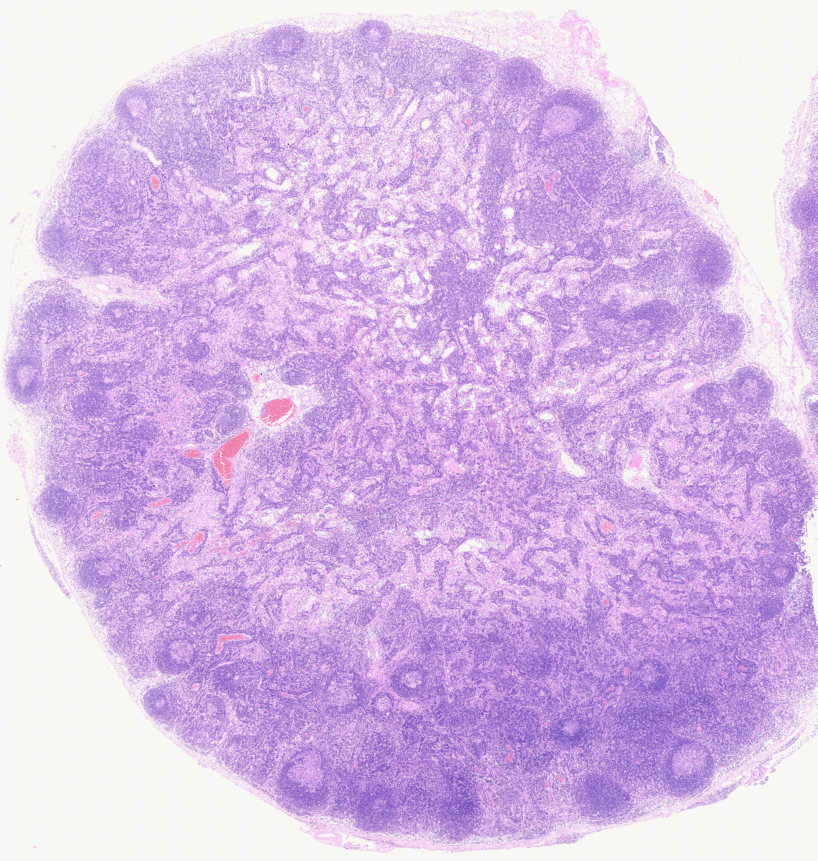

In [6]:
rescale_img

In [7]:
slide_properties = slide.properties
features=[]
values=[]
for i in tqdm(slide.properties.keys()):
  features.append(i)
  values.append(slide.properties[i])
  properties_df=pd.DataFrame([features, values]).transpose()
  properties_df.columns=["features", "values"]

100%|██████████| 26/26 [00:00<00:00, 562.82it/s]


In [8]:
properties_df

features  \
0                    aperio.AppMag   
1                       aperio.MPP   
2                openslide.comment   
3            openslide.level-count   
4    openslide.level[0].downsample   
5        openslide.level[0].height   
6   openslide.level[0].tile-height   
7    openslide.level[0].tile-width   
8         openslide.level[0].width   
9    openslide.level[1].downsample   
10       openslide.level[1].height   
11  openslide.level[1].tile-height   
12   openslide.level[1].tile-width   
13        openslide.level[1].width   
14   openslide.level[2].downsample   
15       openslide.level[2].height   
16  openslide.level[2].tile-height   
17   openslide.level[2].tile-width   
18        openslide.level[2].width   
19                 openslide.mpp-x   
20                 openslide.mpp-y   
21       openslide.objective-power   
22           openslide.quickhash-1   
23                openslide.vendor   
24           tiff.ImageDescription   
25             tiff.ResolutionUnit   

                                               values  
0                                                  40  
1                                            0.241158  
2   Aperio Image Library v10.2.24\r\r\n26187x27552...  
3                                                   3  
4                                                   1  
5                                               27552  
6                                                 256  
7                                                 256  
8                                               26187  
9                                  4.0002291475710354  
10                                               6888  
11                                                256  
12                                                256  
13                                               6546  
14                                 16.003361858190708  
15                                               1722  
16                                                256  
17                                                256  
18                                               1636  
19                                0.24115800000000001  
20                                0.24115800000000001  
21                                                 40  
22  0476f5a54c813d3a24ba666409266d6f31a29accadcd4f...  
23                                             aperio  
24  Aperio Image Library v10.2.24\r\r\n26187x27552...  
25                                               inch

In [9]:
# refer to my notebook: https://www.kaggle.com/code/nghihuynh/wsi-preprocessing-tiling-tissue-segmentation/notebook
def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

def histogram(img, thres_img, img_c, thres):
    """
    style: ['color', 'grayscale']
    """ 
    plt.figure(figsize=(15,15))
    
    plt.subplot(3,2,1)
    plt.imshow(img)
    plt.title('Scaled-down image')
    
    plt.subplot(3,2,2)
    sns.histplot(img.ravel(), bins=np.arange(0,256), color='orange', alpha=0.5)
    sns.histplot(img[:,:,0].ravel(), bins=np.arange(0,256), color='red', alpha=0.5)
    sns.histplot(img[:,:,1].ravel(), bins=np.arange(0,256), color='Green', alpha=0.5)
    sns.histplot(img[:,:,2].ravel(), bins=np.arange(0,256), color='Blue', alpha=0.5)
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.ylim(0,0.05e6)
    plt.xlabel('Intensity value')
    plt.title('Color histogram')
    
    plt.subplot(3,2,3)
    plt.imshow(img_c, cmap='gist_gray')
    plt.title('Complement grayscale image')
    
    plt.subplot(3,2,4)
    sns.histplot(img_c.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.05e6)
    plt.xlabel('Intensity value')
    plt.title('Grayscale complement histogram')
    
    plt.subplot(3,2,5)
    plt.imshow(thres_img, cmap='gist_gray')
    plt.title('Thresholded image')
    
    plt.subplot(3,2,6)
    sns.histplot(thres_img.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.05e6)
    plt.xlabel('Intensity value')
    plt.title('Thresholded histogram')
    
    plt.tight_layout()
    plt.show()

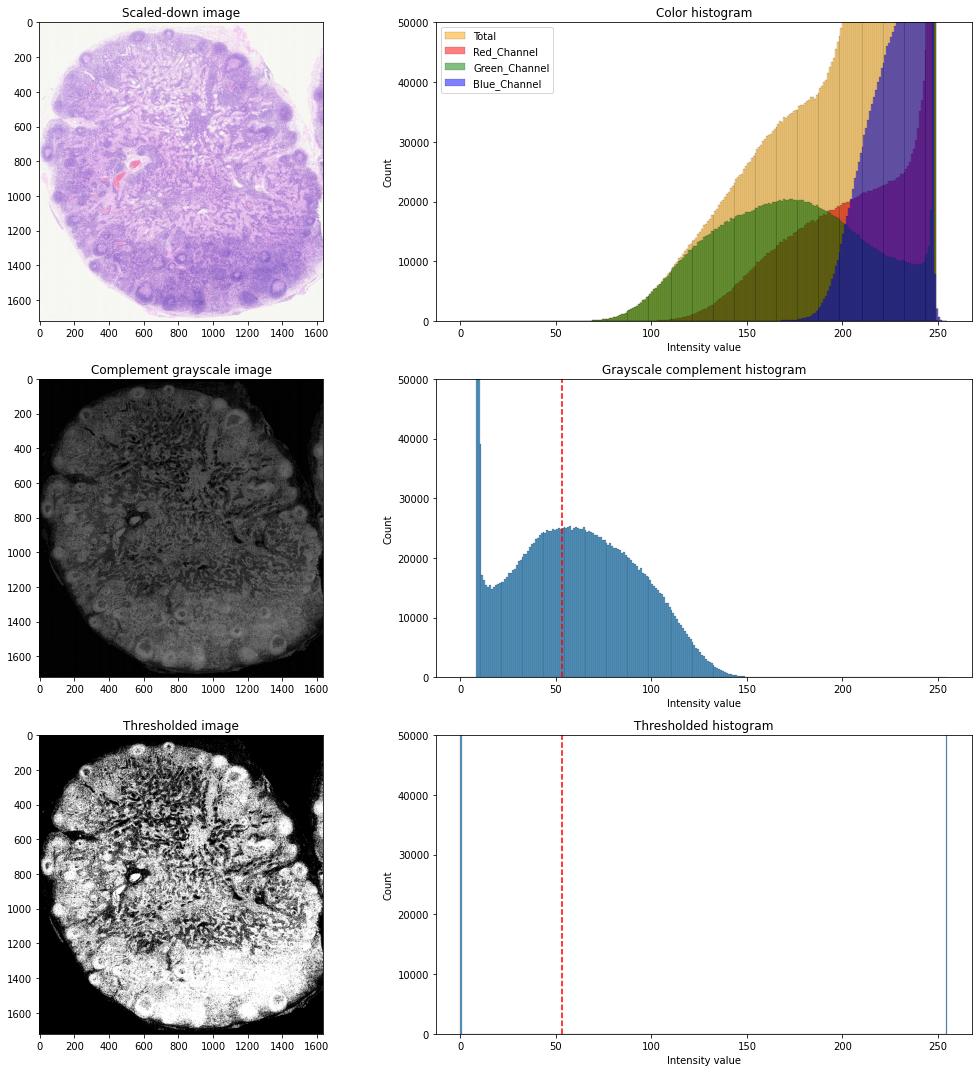

In [10]:
img_np = np.array(rescale_wsi(slide, 16))
thres_otsu, thres_img, img_c = thresholding(img_np, method='otsu')
histogram(img_np, thres_img, img_c, thres_otsu)

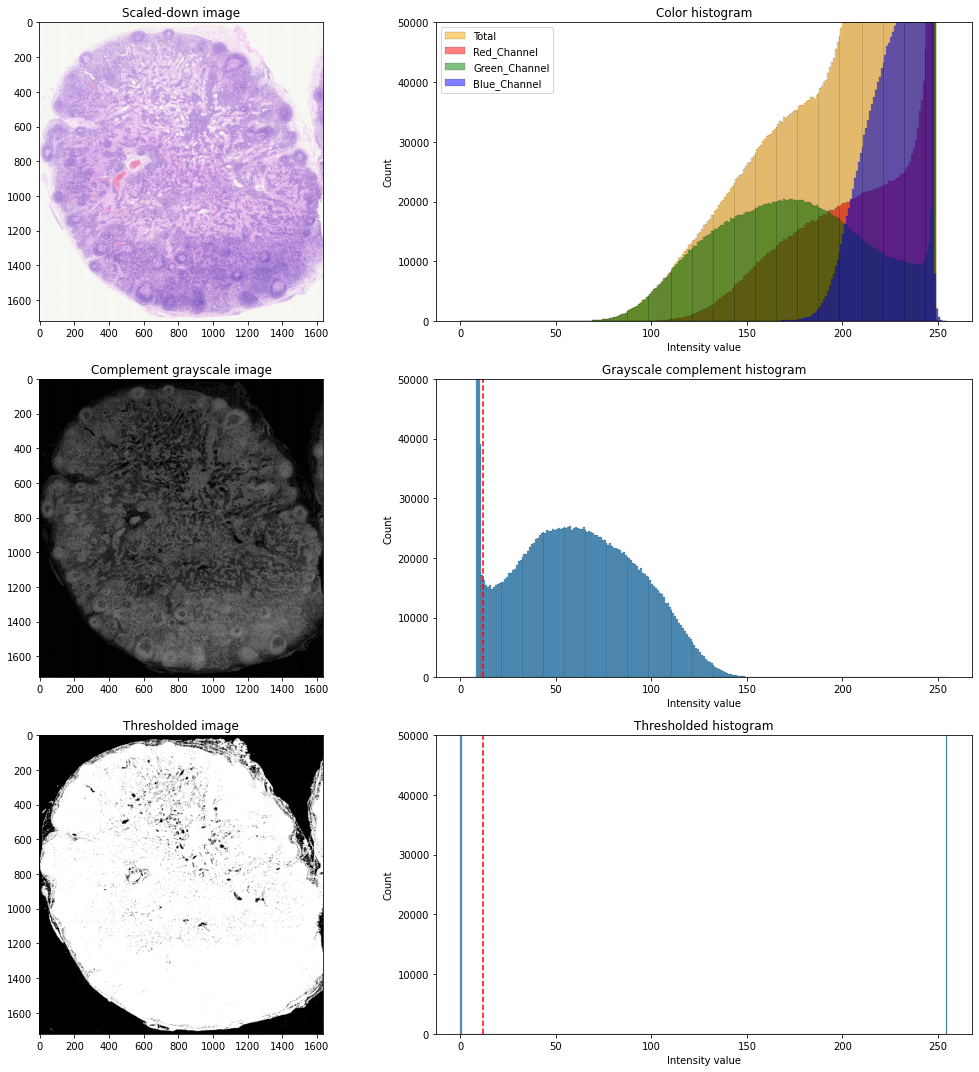

In [11]:
thres_triangle, thres_img, img_c = thresholding(img_np, method='triangle')
histogram(img_np, thres_img, img_c, thres_triangle)

In [12]:
def tile_properties(tiles):
    tile_properties = {'Level count': ['The number of Deep Zoom levels in the image',tiles.level_count], 
            'Tile count': ['The total number of Deep Zoom tiles in the image',tiles.tile_count],
            'Level tiles': ['A list of (tiles_x, tiles_y) tuples for each Deep Zoom level. level_tiles[k] are the tile counts of level k',tiles.level_tiles],
            'Level dimensions': ['A list of (pixels_x, pixels_y) tuples for each Deep Zoom level. level_dimensions[k] are the dimensions of level k',tiles.level_dimensions]
           }
    tile_df = pd.DataFrame.from_dict(tile_properties, orient='index').reset_index()
    tile_df.columns = ['Tile property', 'Description', 'Value']
    return tile_df

def visualize_tiles(tiles, level, thres, tile_size):
    rows, cols = tiles.level_tiles[level]
    plt.figure(figsize=(10,10))
    count = 0
    img_size = 0
    for row in range(rows):
        for col in range(cols):
            count += 1
            plt.subplot(4,4,count)
            plt.xticks([])
            plt.yticks([])
            single_tile = tiles.get_tile(level, (row,col))
            single_tile_RGB = single_tile.convert('RGB')
            img_test = np.array(single_tile_RGB.resize((tile_size, tile_size), Image.BILINEAR))
            img_size = img_test.shape
            plt.imshow(img_test)
            plt.tight_layout()
    plt.suptitle(f'Tile level: {level}\nNum tiles: {count}\nTile size: {img_size}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10,10))
    count = 0
    selected_tiles = 0
    img_size = 0
    for row in range(rows):
        for col in range(cols):
            count += 1
            plt.subplot(4,4,count)
            plt.xticks([])
            plt.yticks([])
            single_tile = tiles.get_tile(level, (row,col))
            single_tile_RGB = single_tile.convert('RGB')
            img_test = np.array(single_tile_RGB.resize((tile_size, tile_size), Image.BILINEAR))
            img_size = img_test.shape
            img_c = 255 - img_test
            if img_c.mean() > thres:
                selected_tiles += 1
                plt.imshow(img_test)
                plt.tight_layout()
    plt.suptitle(f'Tile level: {level}\nNum selected tiles: {selected_tiles}\nTile size: {img_size}')
    plt.tight_layout()
    plt.show()

In [13]:
tiles = DeepZoomGenerator(slide, tile_size=1024, overlap=0, limit_bounds=False)
tile_df = tile_properties(tiles)
tile_df.style.hide_index()

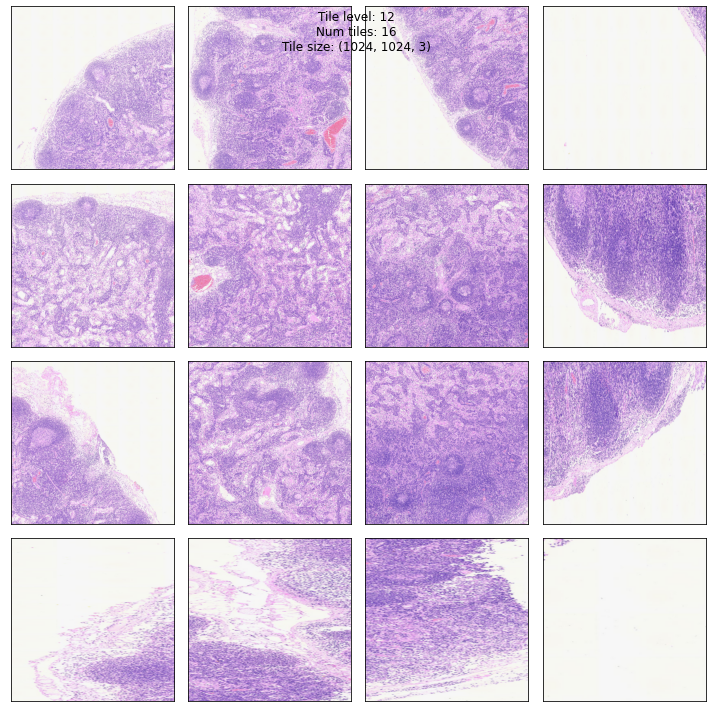

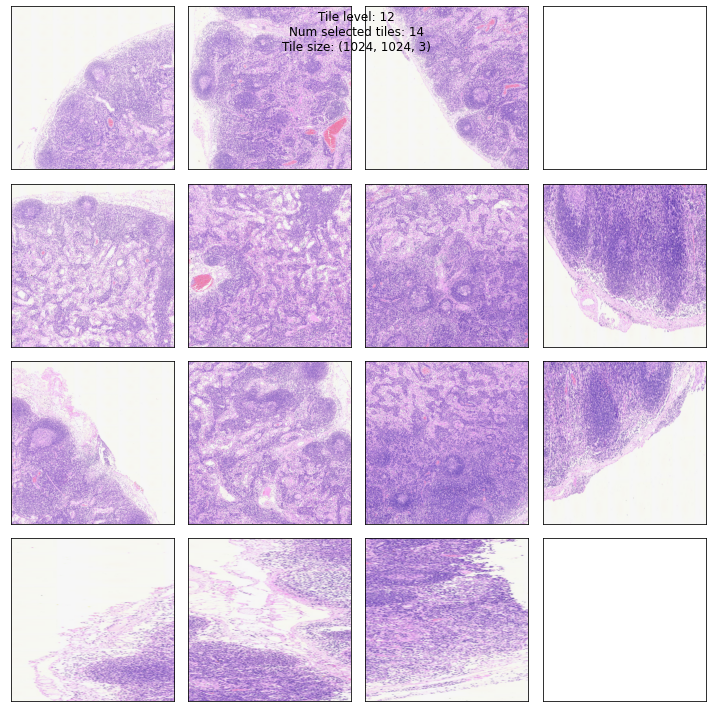

In [14]:
visualize_tiles(tiles, 12, thres_triangle, 1024)